In [1]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import random
import math


@dataclass
class Block:
    x: int
    y: int
    w: int
    h: int

    def __iter__(self):
        return iter((self.x, self.y, self.w, self.h))


@dataclass
class Ceil:
    range: tuple[int, int]
    height: int

    @property
    def len(self):
        return self.range[1] - self.range[0] + 1

    def split(self, length):
        assert self.len >= length
        (start, end) = self.range
        self.range = (start + length, end)
        return Ceil((start, start + length - 1), self.height)

    def merge(self, other):
        assert self.range[1] + 1 == other.range[0]
        self.range = (self.range[0], other.range[1])
        return self

    def as_block(self, bottom_height):
        return Block(self.range[0], self.height, self.len, bottom_height - self.height)


def plot_solution(N, block: list[Block]):
    _, ax = plt.subplots()
    ax.set_xlim(0, N)
    ax.set_ylim(0, N)

    ax.invert_yaxis()

    for i, (sx, sy, w, h) in enumerate(block, start=1):
        color = (random.random(), random.random(), random.random())
        rect_patch = patches.Rectangle(
            (sx, sy), w, h, linewidth=1, edgecolor="black", facecolor=color, alpha=0.4
        )
        ax.add_patch(rect_patch)
        # cx, cy = sx + w / 2, sy + h / 2
        # ax.text(cx, cy, f"{i}", ha="center", va="center", fontsize=15, color="black")

    ax.set_aspect("equal", adjustable="box")
    plt.title("Random Rectangle Tiling")
    plt.show()


def split_ceil(lb: int, ub: int, target_cnt: int, length: int) -> list[int]:
    assert lb <= ub, f"lb({lb}) larger than ub({ub}), please check your input"

    assert (
        lb * target_cnt <= length
    ), f"Can't split length({length}) less than lb({lb})*target_cnt({target_cnt})"

    assert (
        ub * target_cnt >= length
    ), f"Can't split length({length}) more than ub({ub})*target_cnt({target_cnt})"

    if lb * target_cnt == length:
        return [lb] * target_cnt

    if ub * target_cnt == length:
        return [ub] * target_cnt

    ans = [lb] * target_cnt
    length -= lb * target_cnt

    def distribute(idx, leftover):
        rnd = [random.random() for _ in range(len(idx))]
        s = sum(rnd)
        add_up = [int(leftover * r / s) for r in rnd]
        for i, j in enumerate(idx):
            if ans[j] + add_up[i] > ub:
                leftover -= ub - ans[j]
            else:
                leftover -= add_up[i]
            ans[j] = min(ub, ans[j] + add_up[i])
        return leftover

    while length > 0:
        length_left = distribute([i for i, x in enumerate(ans) if x < ub], length)
        if length_left == length:
            for _ in range(length_left):
                candidates = [i for i, x in enumerate(ans) if x < ub]
                ans[random.choice(candidates)] += 1
                length_left -= 1
        length = length_left

    return ans


def place_row(
    H: int,
    lb: int,
    ub: int,
    cnt: int,
    row_cnt: int,
    row_id: int,
    ceils: list[Ceil],
) -> tuple[list[Block], list[Ceil]]:
    cnt_bounds = []
    cnt_lb, cnt_ub = 0, 0

    for ceil in ceils:
        assert ceil.len >= lb, f"Ceil.len({ceil.len}) is smaller than lb({lb})"

        assert not (
            ceil.len > ub and ceil.len < 2 * lb
        ), f"Ceil.len is {ceil.len}, which is larger than ub but less than 2*lb, ub: {ub}, lb: {lb}"

        cur_cnt_lb, cur_cnt_ub = (ceil.len + ub - 1) // ub, ceil.len // lb
        cnt_bounds.append((cur_cnt_lb, cur_cnt_ub))
        cnt_lb, cnt_ub = (
            cnt_lb + cur_cnt_lb,
            cnt_ub + cur_cnt_ub,
        )

    assert cnt_lb <= cnt_ub, f"WTF, cnt_lb is {cnt_lb}, cnt_ub is {cnt_ub}"

    assert (
        cnt_lb <= cnt <= cnt_ub
    ), f"cnt is {cnt}, which should be within range [{cnt_lb}, {cnt_ub}]"

    splitted_ceils = []
    for ceil, (cnt_lb_cur, cnt_ub_cur) in zip(ceils, cnt_bounds):
        cnt_lb, cnt_ub = cnt_lb - cnt_lb_cur, cnt_ub - cnt_ub_cur
        new_cnt_lb_cur = max(cnt_lb_cur, cnt - cnt_ub)
        new_cnt_ub_cur = min(cnt_ub_cur, cnt - cnt_lb)
        cnt_cur = random.randint(new_cnt_lb_cur, new_cnt_ub_cur)
        cnt -= cnt_cur
        for length in split_ceil(lb, ub, cnt_cur, ceil.len):
            splitted_ceils.append(ceil.split(length))
    splitted_ceils.sort(key=lambda ceil: ceil.range[0])

    blocks, merged_ceils = [], []
    ceils_to_merge = []
    height_lb = H - ub * (row_cnt - row_id - 1)
    height_ub = H - lb * (row_cnt - row_id - 1)

    def merge_ceil():
        if not ceils_to_merge:
            return
        height = random.randint(height_lb, height_ub)
        merged_ceil = ceils_to_merge[0]
        blocks.append(ceils_to_merge[0].as_block(height))
        for ceil_to_merge in ceils_to_merge[1:]:
            blocks.append(ceil_to_merge.as_block(height))
            merged_ceil.merge(ceil_to_merge)
        merged_ceil.height = height
        merged_ceils.append(merged_ceil)
        ceils_to_merge.clear()

    for ceil in splitted_ceils:
        new_height_lb = max(height_lb, ceil.height + lb)
        new_height_ub = min(height_ub, ceil.height + ub)
        if random.randint(0, 1) and new_height_lb <= new_height_ub:
            height_lb, height_ub = new_height_lb, new_height_ub
            ceils_to_merge.append(ceil)
        else:
            merge_ceil()
            height_lb = max(H - ub * (row_cnt - row_id - 1), ceil.height + lb)
            height_ub = min(H - lb * (row_cnt - row_id - 1), ceil.height + ub)
            ceils_to_merge.append(ceil)

    merge_ceil()

    return blocks, merged_ceils


def solve(N: int, m: int, lb: int, ub: int) -> list[Block]:
    assert lb <= ub, "WOW, you got lb larger than ub!"
    random.seed(time.time())
    ceils = [Ceil((0, N - 1), 0)]
    blocks = []
    for row_id in range(m):
        ans, ceils = place_row(N, lb, ub, m, m, row_id, ceils)
        blocks.extend(ans)
    return blocks

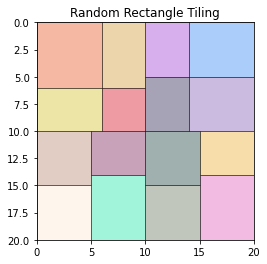

In [2]:
N, m = 20, 4
n = N / m
lb, ub = math.ceil(0.7 * n), math.floor(1.3 * n)
ans = solve(N, m, lb, ub)
for _, _, w, h in ans:
    assert lb <= w <= ub, f"{lb} {w} {ub}"
    assert lb <= h <= ub, f"{lb} {h} {ub}"
plot_solution(N, ans)  # This is time demanding.

In [ ]:
import cProfile
import pstats


def run():
    N, m = 10000, 50
    n = N / m
    lb, ub = math.ceil(0.7 * n), math.floor(1.3 * n)
    ans = solve(N, m, lb, ub)
    for _, _, w, h in ans:
        assert lb <= w <= ub, f"{lb} {w} {ub}"
        assert lb <= h <= ub, f"{lb} {h} {ub}"
    # plot_solution(N, ans)


profiler = cProfile.Profile()
profiler.run("run()")
stats = pstats.Stats(profiler)
stats.sort_stats(pstats.SortKey.TIME).print_stats()

In [3]:
N, m = 10000, 50
n = N / m
lb, ub = math.ceil(0.7 * n), math.floor(1.3 * n)
%prun solve(N, m, lb, ub)

         104686 function calls in 0.047 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       50    0.010    0.000    0.047    0.001 2964879972.py:109(place_row)
     1977    0.005    0.000    0.008    0.000 2964879972.py:85(distribute)
     1443    0.004    0.000    0.014    0.000 2964879972.py:65(split_ceil)
     5987    0.003    0.000    0.005    0.000 random.py:237(_randbelow_with_getrandbits)
     5409    0.003    0.000    0.007    0.000 random.py:290(randrange)
     1492    0.003    0.000    0.009    0.000 2964879972.py:157(merge_ceil)
    12796    0.003    0.000    0.003    0.000 2964879972.py:25(len)
     2500    0.002    0.000    0.003    0.000 2964879972.py:29(split)
     5409    0.002    0.000    0.009    0.000 random.py:334(randint)
     2500    0.002    0.000    0.003    0.000 2964879972.py:40(as_block)
     9529    0.001    0.000    0.001    0.000 {built-in method builtins.min}
     2500    0.001    0.000    